In [1]:
# Install required packages
!pip install datasets
!pip install transformers
!pip install torch
!pip install evaluate
!pip install nltk
!pip install numpy
!pip install pandas
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.2 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.4 MB/s eta 0:00:00


In [2]:
!pip install langchain-text-splitters

In [3]:
pip uninstall wandb

Found existing installation: wandb 0.18.7
Uninstalling wandb-0.18.7:
  Would remove:
    /usr/local/bin/wandb
    /usr/local/bin/wb
    /usr/local/lib/python3.10/dist-packages/package_readme.md
    /usr/local/lib/python3.10/dist-packages/wandb-0.18.7.dist-info/*
    /usr/local/lib/python3.10/dist-packages/wandb/*
Proceed (Y/n)? y
  Successfully uninstalled wandb-0.18.7


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from datasets import Dataset
import torch
import evaluate


from langchain_text_splitters import RecursiveCharacterTextSplitter
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Download NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.environ["WANDB_DISABLED"] = "true"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Mounted at /content/drive


In [5]:
from torch.utils.data import WeightedRandomSampler

In [6]:
import torch
import nltk
from typing import List, Dict
from dataclasses import dataclass
from torch.nn.utils.rnn import pad_sequence
import numpy as np

In [7]:
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

In [8]:
path = '/content/drive/MyDrive/210 Capstone/PC_Classifier/'

In [9]:
def load_data(path):
  train_df = pd.read_csv(path + 'train_aug_df.csv')
  test_df = pd.read_csv(path + 'test_df.csv')
  val_df = pd.read_csv(path + 'val_df.csv')
  return train_df, val_df, test_df

train_df, val_df, test_df = load_data(path)
print("train data shape: ", train_df.shape)
print("val data shape: ", val_df.shape)
print("test data shape: ", test_df.shape)

train data shape:  (17612, 13)
val data shape:  (2162, 12)
test data shape:  (2162, 12)


### 1. Train data

In [10]:
train_df.head(2)

,Unnamed: 0.1,Unnamed: 0,doc_id,test_category,segment_number,unique_policy_identifier,label,policy_category,segment_details,policy_date,url,policy_chunk,sub_labels
0,0,0,23954.0,test_category_labeling_highlight_upitt,123.0,3708.0,42.0,Other,"{""Other Type"": {""endIndexInSegment"": 276, ""sta...",5/29/15,https://www.allstate.com/about/privacy-stateme...,Please send requests to: Allstate Insurance Co...,['Other Type']
1,1,1,17925.0,test_category_labeling_highlight_fordham_ccccc,117.0,3849.0,15.0,User Choice/Control,"{""Choice Type"": {""selectedText"": ""changing the...",5/11/09,http://www.pbs.org/about/policies/privacy-policy/,changing the settings in your web browser Not ...,"['Choice Type', 'Choice Scope', 'User Type', '..."


In [11]:
train_df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)

In [12]:
train_df.head(2)

,doc_id,test_category,segment_number,unique_policy_identifier,label,policy_category,segment_details,policy_date,url,policy_chunk,sub_labels
0,23954.0,test_category_labeling_highlight_upitt,123.0,3708.0,42.0,Other,"{""Other Type"": {""endIndexInSegment"": 276, ""sta...",5/29/15,https://www.allstate.com/about/privacy-stateme...,Please send requests to: Allstate Insurance Co...,['Other Type']
1,17925.0,test_category_labeling_highlight_fordham_ccccc,117.0,3849.0,15.0,User Choice/Control,"{""Choice Type"": {""selectedText"": ""changing the...",5/11/09,http://www.pbs.org/about/policies/privacy-policy/,changing the settings in your web browser Not ...,"['Choice Type', 'Choice Scope', 'User Type', '..."


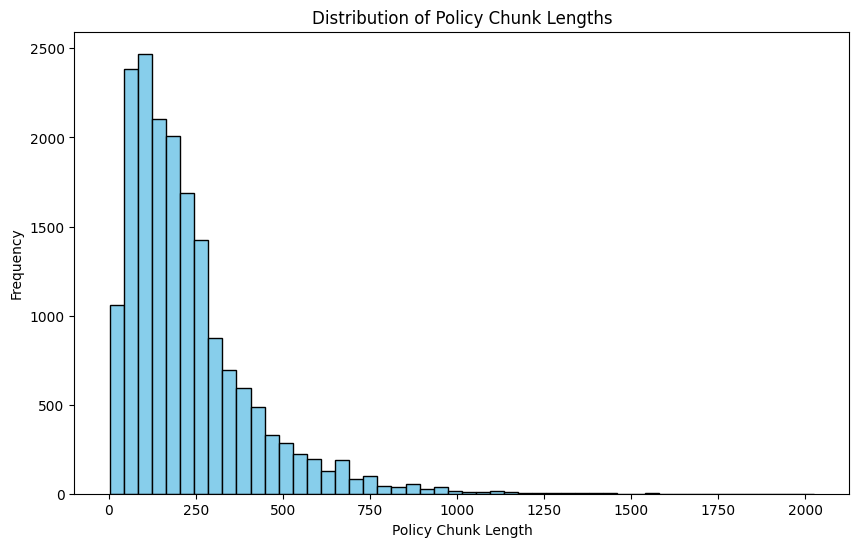

In [13]:
train_df['policy_chunk_length'] = train_df['policy_chunk'].apply(len)

# Plot the distribution
plt.figure(figsize=(10,6))
plt.hist(train_df['policy_chunk_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Policy Chunk Lengths')
plt.xlabel('Policy Chunk Length')
plt.ylabel('Frequency')
plt.show()


In [14]:
from sklearn.preprocessing import LabelEncoder

def prepare_policy_data(train_df, val_df, test_df):
    """
    Prepares the policy dataset for multi-class classification.

    Args:
    - train_df: DataFrame containing the training dataset with columns 'policy_chunk' and 'policy_category'.
    - val_df: DataFrame containing the validation dataset with columns 'policy_chunk' and 'policy_category'.
    - test_df: DataFrame containing the test dataset with columns 'policy_chunk' and 'policy_category'.

    Returns:
    - train_texts, val_texts, test_texts: Lists containing texts for training, validation, and testing.
    - train_labels, val_labels, test_labels: Arrays containing encoded labels for training, validation, and testing.
    - target_names: List of unique labels (policy categories).
    """
    le = LabelEncoder()

    all_labels = pd.concat([train_df['policy_category'], val_df['policy_category'], test_df['policy_category']])
    le.fit(all_labels)

    train_labels = le.transform(train_df['policy_category'])
    val_labels = le.transform(val_df['policy_category'])
    test_labels = le.transform(test_df['policy_category'])

    train_texts = train_df['policy_chunk'].tolist()
    val_texts = val_df['policy_chunk'].tolist()
    test_texts = test_df['policy_chunk'].tolist()

    return train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, le.classes_

train_texts, val_texts, test_texts, train_labels, val_labels, test_labels, target_names = prepare_policy_data(train_df, val_df, test_df)


In [15]:
print(train_labels[:2])
print(train_texts[:2])
print(len(target_names))

[5 9]
['Please send requests to: Allstate Insurance Company Customer Privacy Inquiries, P.O. Box 40047, Roanoke, VA 24022-0047', 'changing the settings in your web browser Not selected null Not selected cookies']
10


In [16]:
print(len(train_texts))
print(len(val_texts))

17612
2162


In [17]:
np_train_labels = np.asarray(train_labels)
np_val_labels = np.asarray(val_labels)
np_test_labels = np.asarray(test_labels)

In [18]:
# Initialize DeBERTa tokenizer and model
model_checkpoint = 'microsoft/deberta-v3-xsmall'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=len(target_names)
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/578 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/241M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-xsmall and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
max_seq_length = 300

# Use DeBERTa tokenizer
train_encodings = tokenizer(train_texts, truncation=True, padding='max_length', max_length=max_seq_length)
val_encodings = tokenizer(val_texts, truncation=True, padding='max_length', max_length=max_seq_length)
test_encodings = tokenizer(test_texts, truncation=True, padding='max_length', max_length=max_seq_length)

# Print shapes for verification
input_ids_shape = len(train_encodings['input_ids']), len(train_encodings['input_ids'][0])
attention_mask_shape = len(train_encodings['attention_mask']), len(train_encodings['attention_mask'][0])

print(f"Train Input IDs shape: {input_ids_shape}")
print(f"Train Attention Mask shape: {attention_mask_shape}")

val_input_ids_shape = len(val_encodings['input_ids']), len(val_encodings['input_ids'][0])
val_attention_mask_shape = len(val_encodings['attention_mask']), len(val_encodings['attention_mask'][0])

print("\nValidation Data:")
print(f"Validation Input IDs shape: {val_input_ids_shape}")
print(f"Validation Attention Mask shape: {val_attention_mask_shape}")

test_input_ids_shape = len(test_encodings['input_ids']), len(test_encodings['input_ids'][0])
test_attention_mask_shape = len(test_encodings['attention_mask']), len(test_encodings['attention_mask'][0])

print("\nTest Data:")
print(f"Test Input IDs shape: {test_input_ids_shape}")
print(f"Test Attention Mask shape: {test_attention_mask_shape}")

Train Input IDs shape: (17612, 300)
Train Attention Mask shape: (17612, 300)

Validation Data:
Validation Input IDs shape: (2162, 300)
Validation Attention Mask shape: (2162, 300)

Test Data:
Test Input IDs shape: (2162, 300)
Test Attention Mask shape: (2162, 300)


In [ ]:
# def compute_sample_weights(df, label_column):
#     """
#     Compute sample weights for multi-class classification based on class imbalance.

#     Parameters:
#     - df: pandas DataFrame containing the training data
#     - label_column: string name of the DataFrame column containing the single class label

#     Returns:
#     - sample_weights: numpy array of sample weights where rows correspond to samples
#     """
#     label_freq = df[label_column].value_counts()

#     label_weights = 1 / label_freq

#     label_weights /= label_weights.sum()

#     label_weight_map = label_weights.to_dict()

#     sample_weights = df[label_column].map(label_weight_map).values

#     return np.array(sample_weights)

# sample_weights = compute_sample_weights(train_df, 'policy_category')

# print(sample_weights[:5])

[0.11523021 0.09284512 0.11523021 0.11523021 0.09284512]


In [20]:
def compute_balanced_weights(df, label_column, power=0.75):
    """
    Compute sample weights with a softer balancing using a power factor

    Parameters:
    - df: DataFrame with the labels
    - label_column: name of the column containing labels
    - power: factor to control the strength of balancing (1.0 is full balancing, 0.0 is no balancing)
    """
    label_freq = df[label_column].value_counts()
    n_samples = len(df)
    n_classes = len(label_freq)

    # Calculate balanced weights with dampening
    weights = (n_samples / (n_classes * label_freq)) ** power

    # Normalize weights
    weights = weights / weights.sum() * n_classes

    # Convert to sample weights
    label_weight_map = weights.to_dict()
    sample_weights = df[label_column].map(label_weight_map).values

    return np.array(sample_weights)

In [21]:
class WeightedTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        self.sampler = kwargs.pop('sampler', None)
        super().__init__(*args, **kwargs)

    def get_train_dataloader(self):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        train_dataset = self.train_dataset
        data_collator = self.data_collator
        dataloader_params = {
            "batch_size": self.args.per_device_train_batch_size,
            "collate_fn": data_collator,
            "num_workers": self.args.dataloader_num_workers,
            "pin_memory": self.args.dataloader_pin_memory,
        }

        if self.sampler is not None:
            dataloader_params["sampler"] = self.sampler
        else:
            dataloader_params["shuffle"] = True

        return torch.utils.data.DataLoader(train_dataset, **dataloader_params)

In [22]:
# Create training dataset
train_dataset = Dataset.from_dict({
    'text': train_texts,
    'label': train_labels
})

# Create validation dataset
val_dataset = Dataset.from_dict({
    'text': val_texts,
    'label': val_labels
})


In [23]:
# 2. Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=300
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/17612 [00:00<?, ? examples/s]

Map:   0%|          | 0/2162 [00:00<?, ? examples/s]

In [24]:
# 3. Setup training arguments

# def get_training_args(num_train_epochs=2):  # Increased from 1 to 2
#     return TrainingArguments(
#         output_dir="./results",
#         num_train_epochs=2,                    # 2 epochs - balanced between time and performance
#         per_device_train_batch_size=8,
#         per_device_eval_batch_size=8,
#         warmup_steps=200,                      # Added modest warmup
#         weight_decay=0.01,
#         learning_rate=3e-5,                    # Slightly adjusted learning rate
#         logging_dir='./logs',
#         logging_steps=10,
#         eval_strategy="epoch",                 # Evaluate each epoch
#         save_strategy="epoch",                 # Save each epoch
#         load_best_model_at_end=True,          # Get best model
#         metric_for_best_model="f1",           # Use F1 score
#         greater_is_better=True,
#         # Add early stopping to save time if model converges
#         )


def get_training_args():
    return TrainingArguments(
        output_dir="./results",
        num_train_epochs=3,                    # Increased epochs
        per_device_train_batch_size=16,        # Larger batch size
        per_device_eval_batch_size=16,
        warmup_ratio=0.1,                      # Warmup ratio instead of steps
        weight_decay=0.01,
        learning_rate=2e-5,                    # Slightly lower learning rate
        logging_dir='./logs',
        logging_steps=10,
        eval_strategy="steps",                 # More frequent evaluation
        eval_steps=100,
        save_strategy="steps",
        save_steps=100,
        load_best_model_at_end=True,
        metric_for_best_model="f1_weighted",   # Use weighted F1 score
        greater_is_better=True
    )

In [25]:
# # 4. Setup metrics computation
# def get_compute_metrics():
#     from sklearn.metrics import accuracy_score, f1_score

#     def compute_metrics(eval_pred):
#         predictions, labels = eval_pred
#         predictions = np.argmax(predictions, axis=1)
#         return {
#             'accuracy': accuracy_score(labels, predictions),
#             'f1': f1_score(labels, predictions, average='weighted')  # Using weighted average for multi-class
#         }
#     return compute_metrics


def get_compute_metrics():
    from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        # Calculate various metrics
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels,
            predictions,
            average='weighted'
        )

        accuracy = accuracy_score(labels, predictions)

        # Also calculate per-class metrics
        per_class_f1 = f1_score(
            labels,
            predictions,
            average=None
        )

        return {
            'accuracy': accuracy,
            'f1_weighted': f1,
            'precision': precision,
            'recall': recall,
            'per_class_f1': per_class_f1.tolist()
        }

    return compute_metrics

In [26]:
# 5 Create trainer
#First tokenize the texts properly
train_encodings = tokenizer(
    train_texts,
    truncation=True,
    padding='max_length',
    max_length=300,
    return_tensors="pt"
)

val_encodings = tokenizer(
    val_texts,
    truncation=True,
    padding='max_length',
    max_length=300,
    return_tensors="pt"
)

# Create datasets with the tokenized data
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'].numpy(),
    'attention_mask': train_encodings['attention_mask'].numpy(),
    'label': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'].numpy(),
    'attention_mask': val_encodings['attention_mask'].numpy(),
    'label': val_labels
})

# Calculate weights using the new balanced weights function
sample_weights = compute_balanced_weights(train_df, 'policy_category', power=0.75)

# Create weighted sampler
weights = [sample_weights[label] for label in train_labels]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

# Get training arguments with new configuration
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,                    # Increased epochs
    per_device_train_batch_size=16,        # Larger batch size
    per_device_eval_batch_size=16,
    warmup_ratio=0.1,                      # Warmup ratio instead of steps
    weight_decay=0.01,
    learning_rate=2e-5,                    # Slightly lower learning rate
    logging_dir='./logs',
    logging_steps=10,
    eval_strategy="steps",                 # More frequent evaluation
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",   # Use weighted F1 score
    greater_is_better=True
)

# Setup trainer with weights
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=get_compute_metrics(),
    tokenizer=tokenizer,
    sampler=sampler
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-21-dc5f92f5a45e>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [27]:
#6 Train
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision,Recall,Per Class F1
100,2.303700,2.320935,0.006013,0.000072,0.000036,0.006013,"[0.0, 0.0, 0.011981566820276499, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
200,2.198300,2.293290,0.137373,0.157146,0.246822,0.137373,"[0.06389776357827476, 0.0, 0.021294021294021293, 0.4900105152471083, 0.0, 0.0, 0.0, 0.0, 0.17154811715481172, 0.0]"
300,1.868100,1.788252,0.455597,0.391051,0.459602,0.455597,"[0.3023255813953488, 0.4140625, 0.07471264367816093, 0.7229580573951435, 0.0, 0.3970802919708029, 0.44274809160305345, 0.0, 0.593939393939394, 0.12941176470588237]"
400,1.243700,1.371252,0.497225,0.403104,0.550069,0.497225,"[0.3006134969325153, 0.49142857142857144, 0.48148148148148145, 0.7287946428571429, 0.46582278481012657, 0.18840579710144928, 0.7058823529411765, 0.0, 0.6845637583892618, 0.3229166666666667]"
500,0.918800,1.039768,0.560130,0.460946,0.753892,0.560130,"[0.8035714285714286, 0.6449864498644986, 0.6666666666666666, 0.7644652250146113, 0.3838383838383838, 0.06963249516441006, 0.7785234899328859, 0.09571788413098237, 0.8117647058823529, 0.7669172932330827]"
600,0.661300,0.867576,0.731730,0.719086,0.815964,0.731730,"[0.5139664804469274, 0.6558265582655827, 0.8387096774193549, 0.8810810810810811, 0.6644736842105263, 0.5096296296296297, 0.6363636363636364, 0.7962085308056872, 0.6909090909090909, 0.7237354085603113]"
700,0.633600,0.611566,0.827012,0.824914,0.863150,0.827012,"[0.8275862068965517, 0.7492795389048992, 0.896551724137931, 0.9305654974946314, 0.6647058823529411, 0.6912325285895807, 0.7307692307692307, 0.897841726618705, 0.8413793103448276, 0.8461538461538461]"
800,0.414900,0.527498,0.840426,0.840365,0.876024,0.840426,"[0.8775510204081632, 0.7071240105540897, 0.896551724137931, 0.9338235294117647, 0.6996904024767802, 0.7275, 0.8169014084507042, 0.9054441260744985, 0.8518518518518519, 0.8708708708708709]"
900,0.332000,0.485004,0.847364,0.846441,0.879815,0.847364,"[0.8461538461538461, 0.7844311377245509, 0.9285714285714286, 0.9423076923076923, 0.6784660766961652, 0.7277289836888331, 0.8, 0.9185393258426966, 0.8089887640449438, 0.8656716417910447]"
1000,0.266400,0.422224,0.865865,0.865432,0.895511,0.865865,"[0.8785046728971962, 0.7295918367346939, 0.9230769230769231, 0.9441997063142438, 0.7781569965870307, 0.7665847665847666, 0.855072463768116, 0.9191489361702128, 0.8957055214723927, 0.8950617283950617]"


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "[0.0, 0.0, 0.011981566820276499, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]" of type <class 'list'> for key "eval/per_class_f1" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Trainer is attempting to log a value of "[0.06389776357827476, 0.0, 0.021294021294021293, 0.4900

TrainOutput(global_step=3303, training_loss=0.43113745713018303, metrics={'train_runtime': 2298.541, 'train_samples_per_second': 22.987, 'train_steps_per_second': 1.437, 'total_flos': 2039693054011200.0, 'train_loss': 0.43113745713018303, 'epoch': 3.0})

In [28]:
# save
model.save_pretrained('/content/drive/MyDrive/210 Capstone/PC_Classifier/model_checkpoints/')
tokenizer.save_pretrained('/content/drive/MyDrive/210 Capstone/PC_Classifier/model_checkpoints/')

('/content/drive/MyDrive/210 Capstone/PC_Classifier/model_checkpoints/tokenizer_config.json',
 '/content/drive/MyDrive/210 Capstone/PC_Classifier/model_checkpoints/special_tokens_map.json',
 '/content/drive/MyDrive/210 Capstone/PC_Classifier/model_checkpoints/spm.model',
 '/content/drive/MyDrive/210 Capstone/PC_Classifier/model_checkpoints/added_tokens.json',
 '/content/drive/MyDrive/210 Capstone/PC_Classifier/model_checkpoints/tokenizer.json')

In [ ]:
# # 2. Load saved model and tokenizer
# drive_path = '/content/drive/MyDrive/PC_Classifier/model_checkpoints/'
# loaded_model = AutoModelForSequenceClassification.from_pretrained(drive_path)
# loaded_tokenizer = AutoTokenizer.from_pretrained(drive_path)

ValueError: Unrecognized model in /content/drive/MyDrive/PC_Classifier/model_checkpoints/. Should have a `model_type` key in its config.json, or contain one of the following strings in its name: albert, align, altclip, audio-spectrogram-transformer, autoformer, bark, bart, beit, bert, bert-generation, big_bird, bigbird_pegasus, biogpt, bit, blenderbot, blenderbot-small, blip, blip-2, bloom, bridgetower, bros, camembert, canine, chameleon, chinese_clip, chinese_clip_vision_model, clap, clip, clip_text_model, clip_vision_model, clipseg, clvp, code_llama, codegen, cohere, conditional_detr, convbert, convnext, convnextv2, cpmant, ctrl, cvt, dac, data2vec-audio, data2vec-text, data2vec-vision, dbrx, deberta, deberta-v2, decision_transformer, deformable_detr, deit, depth_anything, deta, detr, dinat, dinov2, distilbert, donut-swin, dpr, dpt, efficientformer, efficientnet, electra, encodec, encoder-decoder, ernie, ernie_m, esm, falcon, falcon_mamba, fastspeech2_conformer, flaubert, flava, fnet, focalnet, fsmt, funnel, fuyu, gemma, gemma2, git, glm, glpn, gpt-sw3, gpt2, gpt_bigcode, gpt_neo, gpt_neox, gpt_neox_japanese, gptj, gptsan-japanese, granite, granitemoe, graphormer, grounding-dino, groupvit, hiera, hubert, ibert, idefics, idefics2, idefics3, imagegpt, informer, instructblip, instructblipvideo, jamba, jetmoe, jukebox, kosmos-2, layoutlm, layoutlmv2, layoutlmv3, led, levit, lilt, llama, llava, llava_next, llava_next_video, llava_onevision, longformer, longt5, luke, lxmert, m2m_100, mamba, mamba2, marian, markuplm, mask2former, maskformer, maskformer-swin, mbart, mctct, mega, megatron-bert, mgp-str, mimi, mistral, mixtral, mllama, mobilebert, mobilenet_v1, mobilenet_v2, mobilevit, mobilevitv2, moshi, mpnet, mpt, mra, mt5, musicgen, musicgen_melody, mvp, nat, nemotron, nezha, nllb-moe, nougat, nystromformer, olmo, olmoe, omdet-turbo, oneformer, open-llama, openai-gpt, opt, owlv2, owlvit, paligemma, patchtsmixer, patchtst, pegasus, pegasus_x, perceiver, persimmon, phi, phi3, phimoe, pix2struct, pixtral, plbart, poolformer, pop2piano, prophetnet, pvt, pvt_v2, qdqbert, qwen2, qwen2_audio, qwen2_audio_encoder, qwen2_moe, qwen2_vl, rag, realm, recurrent_gemma, reformer, regnet, rembert, resnet, retribert, roberta, roberta-prelayernorm, roc_bert, roformer, rt_detr, rt_detr_resnet, rwkv, sam, seamless_m4t, seamless_m4t_v2, segformer, seggpt, sew, sew-d, siglip, siglip_vision_model, speech-encoder-decoder, speech_to_text, speech_to_text_2, speecht5, splinter, squeezebert, stablelm, starcoder2, superpoint, swiftformer, swin, swin2sr, swinv2, switch_transformers, t5, table-transformer, tapas, time_series_transformer, timesformer, timm_backbone, trajectory_transformer, transfo-xl, trocr, tvlt, tvp, udop, umt5, unispeech, unispeech-sat, univnet, upernet, van, video_llava, videomae, vilt, vipllava, vision-encoder-decoder, vision-text-dual-encoder, visual_bert, vit, vit_hybrid, vit_mae, vit_msn, vitdet, vitmatte, vits, vivit, wav2vec2, wav2vec2-bert, wav2vec2-conformer, wavlm, whisper, xclip, xglm, xlm, xlm-prophetnet, xlm-roberta, xlm-roberta-xl, xlnet, xmod, yolos, yoso, zamba, zoedepth

In [ ]:
# # 2. Recreate training arguments
# def get_training_args(num_train_epochs=1):
#     return TrainingArguments(
#         output_dir="./results",
#         num_train_epochs=1,
#         per_device_train_batch_size=8,
#         per_device_eval_batch_size=8,
#         warmup_steps=0,
#         weight_decay=0.01,
#         learning_rate=5e-5,
#         logging_dir='./logs',
#         logging_steps=10,
#         eval_strategy="no",
#         save_strategy="no",
#         load_best_model_at_end=False
#     )

In [ ]:
# # 3. Create new trainer with loaded model
# training_args = get_training_args()
# new_trainer = Trainer(
#     model=loaded_model,
#     args=training_args,
#     tokenizer=loaded_tokenizer,
# )


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-17-2e8fa8399fb7>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  new_trainer = Trainer(


In [29]:
# Evaluation
val_predictions = trainer.predict(val_dataset)
predictions = np.argmax(val_predictions.predictions, axis=1)

# Print detailed metrics
from sklearn.metrics import classification_report
print("\nDetailed Classification Report:")
print(classification_report(
    val_labels,
    predictions,
    target_names=target_names,
    zero_division=1
))


Detailed Classification Report:
                                      precision    recall  f1-score   support

                      Data Retention       0.94      0.90      0.92        52
                       Data Security       0.76      0.94      0.84       149
                        Do Not Track       0.93      1.00      0.96        13
          First Party Collection/Use       0.97      0.99      0.98       658
International and Specific Audiences       0.88      0.93      0.90       121
                               Other       0.97      0.84      0.90       497
                       Policy Change       0.85      0.97      0.91        60
      Third Party Sharing/Collection       1.00      0.97      0.98       378
      User Access, Edit and Deletion       0.84      0.88      0.86        80
                 User Choice/Control       0.88      0.97      0.92       154

                            accuracy                           0.94      2162
                           ma

In [30]:
# Get predictions
val_outputs = trainer.predict(val_dataset)
val_predictions = val_outputs.predictions
predicted_labels = np.argmax(val_predictions, axis=1)  # For multi-class classification

print("Predicted labels:", predicted_labels)

# If you want to see actual category names
predicted_categories = [target_names[label] for label in predicted_labels]
print("\nFirst few predictions:")
for i in range(5):  # Show first 5 predictions
    print(f"Text: {val_texts[i][:100]}...")  # Show first 100 chars
    print(f"Predicted category: {predicted_categories[i]}\n")

Predicted labels: [7 9 3 ... 5 1 5]

First few predictions:
Text: with companies, organizations and individuals outside of Google Not selected Not selected personal i...
Predicted category: Third Party Sharing/Collection

Text: email us free email subscription registering registering for a particular newsletter email...
Predicted category: User Choice/Control

Text: we ask for null When you register your name, email address null you are not anonymous to us. null Wh...
Predicted category: First Party Collection/Use

Text: Barnes & Noble complies with the U.S. - E.U. Safe Harbor framework and the U.S. - Swiss Safe Harbor ...
Predicted category: International and Specific Audiences

Text: Not selected Not selected Not selected demographics Not selected non-personally identifiable informa...
Predicted category: First Party Collection/Use



                                      precision    recall  f1-score   support

                      Data Retention       0.94      0.90      0.92        52
                       Data Security       0.76      0.94      0.84       149
                        Do Not Track       0.93      1.00      0.96        13
          First Party Collection/Use       0.97      0.99      0.98       658
International and Specific Audiences       0.88      0.93      0.90       121
                               Other       0.97      0.84      0.90       497
                       Policy Change       0.85      0.97      0.91        60
      Third Party Sharing/Collection       1.00      0.97      0.98       378
      User Access, Edit and Deletion       0.84      0.88      0.86        80
                 User Choice/Control       0.88      0.97      0.92       154

                            accuracy                           0.94      2162
                           macro avg       0.90      0.94     

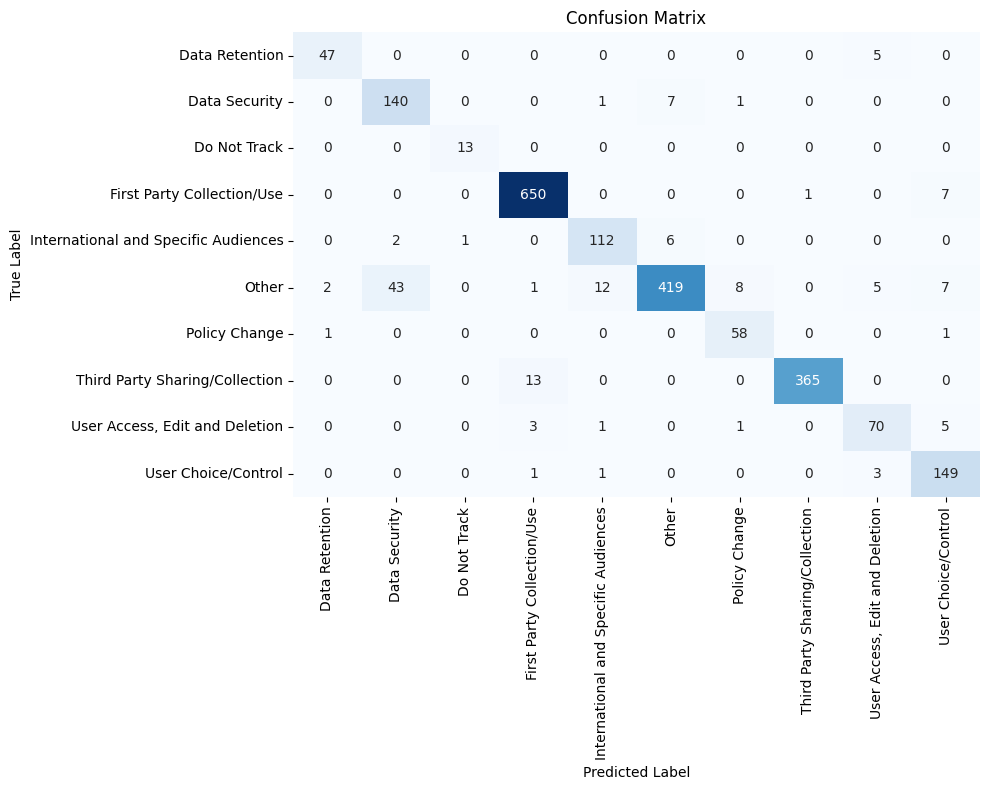

In [31]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def show_results_multiclass_deberta(trainer, dataset, true_labels, classes):
    # Get predictions
    outputs = trainer.predict(dataset)
    prob_predictions = outputs.predictions
    yhat_val = np.argmax(prob_predictions, axis=1)

    # Print classification report
    print(classification_report(true_labels, yhat_val, target_names=classes, zero_division=1))

    # Create confusion matrix
    conf_matrix = confusion_matrix(true_labels, yhat_val)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=False,
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Use the function
show_results_multiclass_deberta(
    trainer,
    val_dataset,
    val_labels,
    target_names
)

Map:   0%|          | 0/2162 [00:00<?, ? examples/s]

                                      precision    recall  f1-score   support

                      Data Retention       0.92      0.92      0.92        53
                       Data Security       0.73      0.93      0.81       149
                        Do Not Track       0.92      0.92      0.92        13
          First Party Collection/Use       0.97      0.99      0.98       658
International and Specific Audiences       0.83      0.84      0.84       120
                               Other       0.95      0.84      0.89       497
                       Policy Change       0.87      0.97      0.91        60
      Third Party Sharing/Collection       0.99      0.96      0.98       378
      User Access, Edit and Deletion       0.88      0.91      0.90        80
                 User Choice/Control       0.90      0.95      0.92       154

                            accuracy                           0.93      2162
                           macro avg       0.90      0.92     

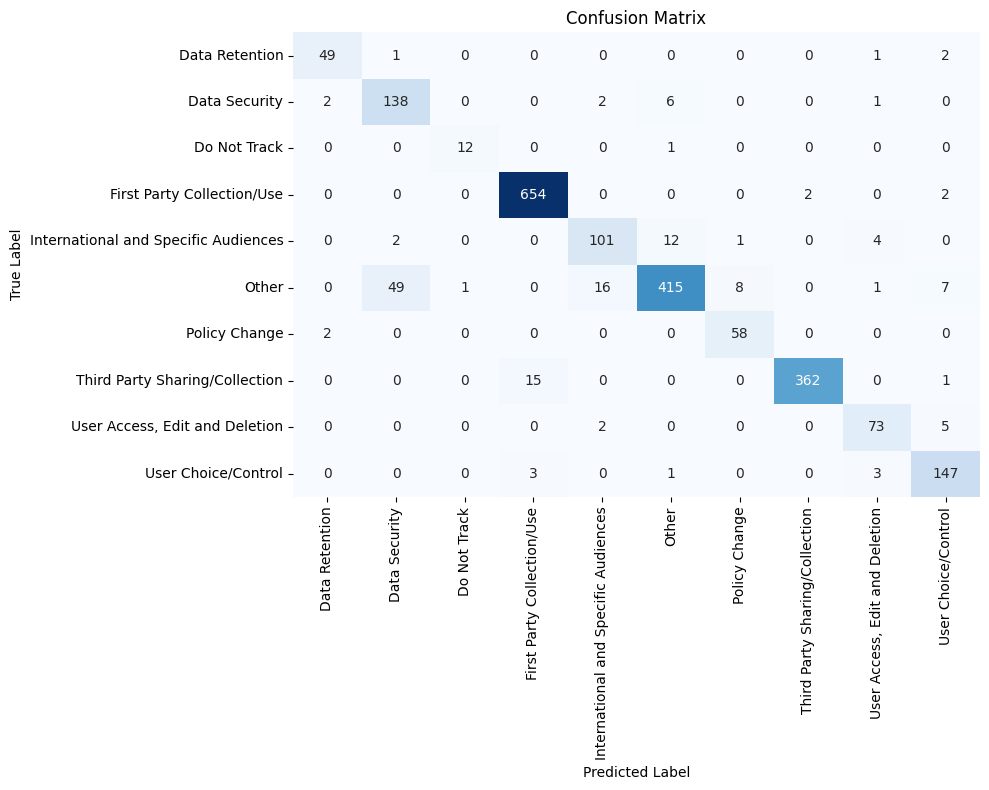

In [32]:
def show_results_multiclass(trainer, dataset, true_labels, classes):
    # Get predictions using trainer instead of model.predict
    outputs = trainer.predict(dataset)
    prob_predictions = outputs.predictions
    yhat_val = np.argmax(prob_predictions, axis=1)

    print(classification_report(true_labels, yhat_val, target_names=classes, zero_division=1))

    conf_matrix = confusion_matrix(true_labels, yhat_val)

    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                cbar=False,
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Create test dataset for DeBERTa
test_dataset = Dataset.from_dict({
    'text': test_texts,
    'label': test_labels
})

# Tokenize test dataset
def tokenize_function(examples):
    return tokenizer(
        examples['text'],
        padding='max_length',
        truncation=True,
        max_length=300
    )

test_dataset = test_dataset.map(tokenize_function, batched=True)

# Show results
show_results_multiclass(
    trainer,
    test_dataset,
    test_labels,
    target_names
)

In [ ]:
# import nltk
# nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [33]:
# Test with a full privacy policy
full_policy ="""Privacy Notice | BitPay
For Individuals
For Businesses
For Individuals
For Businesses
Developers
Help
For Individuals
Buy Crypto
Buy Bitcoin (BTC)
Buy Ether (ETH)
Buy Litecoin (LTC)
Buy Bitcoin Cash (BCH)
Buy Dogecoin (DOGE)
Buy USD Coin (USDC)
Buy 60+ cryptocurrencies
Sell Crypto
Sell Bitcoin (BTC)
Sell Ether (ETH)
Sell Litecoin (LTC)
Sell Bitcoin Cash (BCH)
Sell Dogecoin (DOGE)
Sell USD Coin (USDC)
Sell 60+ cryptocurrencies
Store Crypto
BitPay Wallet
Bitcoin Wallet
Ethereum Wallet
Tether Wallet
Polygon Wallet
Litecoin Wallet
Pay with Crypto
Debit Card
Merchant Directory
Buy Gift Cards
Browser Extension
Bill Pay
Learn
Blog
Crypto Stats
For Businesses
Accept Crypto
Online Payments
Billing
Retail
Send Crypto
Crypto Payroll
Customer Rewards & Rebates
Marketplace & Affiliates
Use Cases
NFTs
Nonprofits
Resources
Articles
Crypto Stats
Developers
Help
Log In
Privacy Notice
EU Privacy Notice
Cookie Policy
Exercise Your Rights
Manage Cookies
EU Privacy Notice
Privacy Notice
EU Privacy Notice
Exercise Your Rights
Manage Cookies
EU Privacy Notice Updated May 19, 2020
Scope
Responsibility
What is "personal data"?
How we obtain personal data
Who are the data subjects?
Details of data processing
How we protect and store personal information
Data retention
How we share personal data with third parties and transfers outside the EEA
Your rights
Marketing
Contact Information Scope
This EU Privacy Notice (“Notice”) describes the ways BitPay Inc. (“BitPay”, “we”, “us”, “our”) collects,
stores, uses and protects
personal data. BitPay’s services include Merchant processing services, websites, mobile applications,
products, and other features, technologies or functionalities, including customer support (the
“Services”) offered by us. This Notice applies to all processing of personal data on the website
www.bitpay.com
and all other BitPay sites on which it appears (the “Sites”).
The purpose of this Notice is to inform you about the processing of personal data by us and to inform
you of your rights.
Responsibility Compliant processing. BitPay complies with applicable United States
federal and state regulations and
European Economic Area (European Union + Norway, Iceland, Liechtenstein) (hereinafter “EEA”) data
protection laws, such as the General Data Protection Regulation and its implementation acts (hereinafter
“GDPR”).
BitPay as a controller. BitPay is considered the controller
for processing personal data as described in this Notice.
BitPay as a processor. In principle, we control the processing of your
personal data. However, in some cases, we may process your personal data on behalf of another party, who
is the controller responsible for your personal data. This Notice does not relate to that part of our
processing activities where we are acting on behalf of another controller. For such processing, the
privacy notice of the relevant controller applies, and we encourage you to read that notice.
Third party websites. The Sites may include links to websites of third
parties (for example, hyperlinks, banners or buttons). We are not responsible for the content of those
websites, services provided by those third parties, or their compliance with applicable privacy
legislation.
What is “personal data”?
Personal data is any information relating to an identified natural person or that can be used to
identify a natural person directly or indirectly. A prime example of identifiable information is a
person’s legal full name.
How we obtain personal data Means of collection. We obtain your personal data in various ways:
Provided by you. We obtain information provided by you, for example,
if you contact us, sign up for our newsletter, or provide information to us in the course of using our
Services. When you provide personal data to BitPay, please do not provide information that is
irrelevant, inaccurate, and/or unnecessary for the provision of Services.
Automatically collected. We obtain some information automatically
when you visit our Sites, for example, via cookies. For more information, please see our
Cookie Policy.
Third parties. We may obtain information from third parties, such as
our Merchants with which you do business.
Required provision. It may be that providing certain personal data to
us is a statutory or contractual requirement, a requirement necessary to enter into a contract, or that
you are otherwise obliged to provide. If that is the case, we will inform you thereof and will explain
the possible consequences if you fail to provide such personal data to us.
Who are the data subjects?
There are several types of data subjects whose personal data we process:
Visitors of our Sites;
Merchants who sign up for our Services (“Merchants” means any business that uses our Services to
process payments, including non-profits that use our Services to accept donations and “Aggregators”
that use our Services as a payment services platform for their own Merchants);
Shoppers of Merchants (“Shoppers” means individuals who indirectly interface with BitPay when paying a
Merchant’s invoice that is forwarded by BitPay to a Merchant during checkout, when requesting a refund
from a Merchant, when creating a BitPay account, or when making a donation to a non-profit);
BitPay wallet holders who have downloaded and installed the BitPay app on their mobile device;
Payees (e.g., employees, contractors, vendors or exchange customers) who request a payment (“Payout”)
via cryptocurrency from a Merchant and create a BitPay account; and
Partner employees (employees and other agents of our customers and vendors, including potential and
former customers and vendors).
Details of data processing: What kind of personal data do we collect, why, and on what legal
basis? The categories of personal data we collect, the purposes, and the legal bases are set forth below. Our
primary purpose for collecting personal data is to provide you with a secure, smooth, efficient, and
customized experience. We use your personal data to: Provide our Services (including customer support);
Process transactions and send notices about your transactions;
Resolve disputes, collect fees, and troubleshoot problems; Communicate with you about our Services and business and to inform you of matters
that are important for your account and/or use of the Sites. We also use your personal data to respond
to any questions, comments or requests you filed with us and the handling of any complaints;
Comply with applicable laws and regulations;
Establish, exercise and defend legal claims; Monitor and report compliance issues;
Customize, measure, and improve our business, the Services, and the content and
layout of our website and applications (including developing new products and services; managing our
communications; determining the effectiveness of our sales, marketing and advertising; analyzing and
enhancing our products, services, websites and apps; ensuring the security of our networks and
information systems; performing accounting, auditing, invoicing, reconciliation and collection
activities; and improving and maintaining the quality of our customer services);
Perform data analysis; Deliver targeted marketing, service update notices, and promotional offers based on
your communication preferences, and measure the effectiveness of it. To approach you via email for
marketing purposes, we request your consent, unless it is not required by law. You always have the
option to unsubscribe from our mailings, e.g., via the unsubscribe link in our newsletter;
Perform risk management, including comparing information for accuracy and verify it
with third parties and protect against, identify and prevent fraud and other prohibited or illegal
activity, claims and other liabilities; and
Enforce our contractual terms. We only use your personal data where we have a legal basis to do so: Consent. For some processing activities, we require your prior consent. This applies
for example to some of our direct marketing activities which fall under the scope of the GDPR and
ePrivacy rules. You may withdraw your consent at any time (see below).
Performance of a contract. Some personal data we process about you is for the
performance of a contract to which you are a party or in order to take steps at your request prior to
entering into a contract with us.
Legal obligation. In some cases, we have to process your personal data to comply with
legal obligations, including those applicable to financial services institutions, such as under the
Bank Secrecy Act and other anti-money laundering laws.
Legitimate interest. In most cases where we process personal data in the context of
our Services we rely on our legitimate interests in conducting our normal business as an online
payments company as a legal basis for such processing.
Where we process personal data relating to criminal convictions and offenses, we will ensure that we
have a lawful basis to do so. The following sections provide you with some more information.
1. Visitors of Our Sites
Categories of personal data: We may collect the following
personal data of Visitors of our Sites:
Technical information, including IP address; the type of browser, devices and operating systems
you use; identifiers associated with the device(s) you use to access our Sites; the pages you
visit and the features you use; access dates and times; and if you navigated from or navigate to
another website, the address of that website; and information regarding your internet service
provider
Email address (e.g., when you subscribe to our blog or opt in to receive other marketing
materials)
Phone number (e.g., when you contact our sales or media team or opt in to our media list)
Full name (e.g., when you submit a support request)
Country
Cookies: For more information about our use of cookies, please
see our
Cookie Policy.
Collection of personal data: Your personal data is collected by
us when you:
request a BitPay newsletter or content using one of our web forms;
register on the Sites; and
otherwise use the Sites
2. Merchants (including businesses such as nonprofits and Aggregators)
Categories of personal data: We may collect the following
personal data of the beneficial owner or
any user that is added to an account of a Merchant (including nonprofits and Aggregators that use
our Services as a payment services platform for their own Merchants). In the case of Aggregators,
we may collect the personal data of that Aggregator’s Merchants. The elements we collect depend on
our compliance analysis and your risk profile.
Full name of beneficial owner Full names of authorized users Merchant email address (business domain preferred but non-business domain accepted) Full physical address (no post office boxes) Business phone number ID of beneficial owner and authorized user(s) Tax ID (if applicable in specific country) Proof of business Proof of address, if not evident in above documents 3 most recent bank statements or bank letter of good standing Bank account details Collection of personal data: Your personal data is collected by
us when you register for a
Merchant account. We may also obtain information about our Merchants from third parties that
provide identity verification and fraud prevention services, and from relevant Aggregators.
3. Shoppers of Merchants
Categories of personal data: We may collect the following
personal data when you as a Shopper indirectly interface with BitPay when you pay a Merchant’s
invoice, request a refund and/or make donations.
When you pay a BitPay invoice, we collect: Technical information including IP addresses used to view the BitPay invoice; the type of
browser, devices and operating systems you use; identifiers associated with the device(s)
you use to access our sites; the pages you visit and the features you use; access dates and
times; and if you navigated from or navigate to another website, the address of that
website; and information regarding your internet service provider
Products purchased and price at the relevant Merchant Email address Crypto wallet address When you request a refund, we collect: Amount Currency Email address Crypto wallet address Invoice ID When you make a donation, we may collect, depending on the circumstances: Amount Currency Email address Full name Address Phone number Employer Job title City of employment Certain Shoppers may choose to or may be required to create a BitPay account. When you create a BitPay account, we may collect additional information from you. Collection of personal data for invoices: Your personal data is
collected by us either as provided by the Merchant or as manually entered by you. This is
necessary for invoicing, enables us to comply with financial regulations, and creates a more
seamless payment experience for both the Merchant and the Shopper. It also enables us to send an
email to a Shopper to obtain a cryptocurrency refund address in case of a payment exception (e.g.,
overpayments, underpayments, etc.).
Collection of personal data for refunds: A Merchant has the
option to claim a refund via its own BitPay dashboard in case of a payment exception (e.g.,
overpayments, underpayments, etc.). You receive a special link to your email address with
instructions to claim a refund. You have to reach out to the Merchant by email and provide your
personal data.
Collection of personal data for donations: A Merchant collects
data from the donation page on the Merchant’s website (created by the Merchant within its own
dashboard).
4. BitPay Wallet Holders
Categories of personal data: We collect the following personal
data when you create a BitPay non-custodial wallet via the BitPay app:
Email address Wallet name Copayer name Wallet public key Wallet extended public key Wallet coin Wallet multi-sig setup Transaction details Type of phone, OS and version, App version, IP address Wallet ID (Client ID) App Token API Authentication Token Collection of personal data: Your personal data is collected by
us when you enter it into the BitPay App.
5. Payees of Merchants
Categories of personal data: When you as a Payee request or
receive a cryptocurrency payment from a Merchant using the Services, you must create a BitPay
account. We will process the following personal data in order to provide you with a Payout:
Name Email address Walled address/provider Identification documents (such as a passport or a driver's license) Proof of address document (such as a bank statement or a utility bill) Collection of personal data: The Merchant will confirm your
BitPay wallet address so that you can receive the Payout.
6. Employees of Partners
Categories of personal data: We process data about former,
existing and prospective vendors and customers, including Merchants (together, “Partners”). This
includes limited personal data about employees and agents of such Partners (“Partner Employees”)
at the beginning and throughout the course of the Partner relationships. We may process:
Professional contact information (e.g., name, postal address, email address, fax number, phone
number, mobile phone number)
Professional information (e.g., profession and title, place of work, and relationship to our
Partner)
Collection of personal data: We may collect personal data from
you, your employer or colleagues. In very limited cases, it may be a contractual requirement for
us to collect such personal data from Partner Employees (for example, because the Partner Employee
is a designated “point of contact” and if this information is not collected, it could result in a
breach of contract by us or the Partner.)
Specification of legitimate interests. Prior to processing your
personal data on the basis of legitimate interests, we have assessed whether our legitimate business
interests are not overridden by your rights and freedoms. You can contact us for information about the
‘balancing test’ that we conducted to rely on this legal basis. Please find our contact details below.
How we protect and store personal information
We take the security of our data seriously. We use administrative, technical, and physical security
designed to safeguard personal data in our possession, and we maintain internal policies and procedures
to address our data security. We have been audited and received a SOC 2 report addressing the security
of our Services. However, we cannot guarantee the security of the data
that we collect and store. We will notify relevant supervisory authorities and data subjects in the
event of a data breach, if required under applicable law.
Data retention
In principle, we do not store your personal data any longer than is strictly necessary for processing
purposes. We have a retention policy to ensure that your personal data is retained and deleted in
accordance with applicable retention periods. Because we are a regulated financial institution in the
United States, we retain personal data collected as a part of our customer due diligence and
identification program, as required by applicable federal and state regulations.
For further information on our data retention policy, please find our contact details below.
How we share personal data with third parties and transfers outside the EEA Third parties. We may share your personal data with the following third
parties:
Other BitPay entities, including to help detect and prevent potentially illegal acts and violations
of our policies, and to guide decisions about our products, services and communications;
Service providers who help with our business operations and to deliver our Services, such as:
Cloud service providers providing cloud infrastructure; Providers of ID verification solutions and other due diligence solutions (such as KYC and
anti-money laundering);
Providers of website analytics; Providers of customer service solutions outside of the EEA; Providers of marketing automation platforms in the United States
Law enforcement, government officials, regulatory agencies, our banks, and other third parties
pursuant to a
subpoena, court order or other legal process or requirement if applicable to BitPay; or when we
believe, in our sole discretion, that the disclosure of data is necessary to report suspected illegal
or fraudulent activity or to investigate violations of our Terms of Use; and
We may also share certain Shopper data with our Merchants, for example, in cases of suspected fraud or
in connection with an ongoing investigation.
Transfers outside the EEA. BitPay is primarily located in the United
States, and some of the third parties mentioned above may be located in the United States or other
countries outside the EEA. We employ the following safeguards if the
processing of personal data by us qualifies as a transfer of personal data outside the EEA and falls
within the scope of the GDPR:
We may transfer your personal data to countries that have been found to provide an adequate level of
protection of personal data
We may use specific contracts, including Standard Contractual Clauses. For example, we offer Standard
Contractual Clauses to meet data transfer requirements in respect of third parties such as service
providers
You can obtain a copy of such contracts or information about countries in which we have service
providers by contacting us. Please find our contact details below.
Your rights
Under the GDPR and relevant implementation acts, individuals have statutory rights related to their
personal data. For more information on your rights, please refer to
this web page
of the European Commission. Please note that rights are not absolute and may be subject to
conditions.
One key right is the Right to object. You have the right to object to processing of
your personal data
where we are relying on legitimate interests as our legal basis (see above). Under certain
circumstances, we may have compelling legitimate grounds that allow us to continue processing your
personal data. Insofar as the processing of your personal data takes place for direct marketing
purposes, including profiling for direct marketing, we will always honor your request.
Other rights are as follows: Right to withdraw consent. Insofar as our processing of your personal data is based
on your consent (see above), you have the right to withdraw consent at any time.
Right of access. You have the right to request access to your personal data.
Right to rectification. You have the right to request rectification of the personal
data that we hold about you.
Right to erasure. You have the right to request erasure of your personal data. This
enables you to ask us to delete or remove personal data in certain circumstances.
Right to restriction. You have the right to request restriction of processing of your
personal data.
Right to data portability. In some cases, you have the right to request to transfer
your personal data to you or to a third party of your choice.
How to exercise your rights. The exercise of the aforementioned rights
is free of charge and can be
carried out by visiting our
Data Subject Rights Portal.
(You can also contact us by email via the contact details below, but you will receive a reply
email directing you to our Data Subject Rights
Portal so it is easier to go straight to our portal).
Merchants can review and edit their personal data by logging into their account and reviewing their
personal data under the Settings tab on their Merchant dashboard. If you wish to change information
relating to your industry or company website, or if you wish to close your account, you can submit a
request at
https://support.bitpay.com.
If you choose to close your BitPay account, we will
mark your account in our database as "closed". We will retain the information in the account in
accordance with the record retention principles outlined in this Privacy Notice and as required by
applicable law.
Marketing
If you do not wish to receive marketing communications from us or participate in our ad customization
programs, you can simply click the “unsubscribe” link at the bottom of an email you receive from us or
you can send an email to marketing@bitpay.com.
Contact Information Contact DPO. BitPay has appointed a Data Protection Officer. You may
contact us with questions or concerns about our privacy policies or practices at dpo@bitpay.com.
However, If you wish to submit a data privacy rights request, you may do so by visiting our
Data Subject Rights Portal.
Complaints. Subject to applicable law, you also have the right to lodge
a complaint with your local Data
Protection Authority. If you believe we maintain your personal data within the scope of the GDPR, and if
you believe we did not take action in respect of your data subject rights (as set out above) or you are
not satisfied with the way in which we have handled your request, you may lodge a complaint with a
supervisory authority or seek a judicial remedy. The Dutch Data Protection Authority (Autoriteit
Persoonsgegevens) is BitPay’s lead supervisory authority in the EU.
However, we would always appreciate the chance to address your concerns before you approach the
supervisory authority, so please contact our Data Protection Officer with questions or concerns by
sending an email to dpo@bitpay.com or mail to: BitPay B.V., the
representative of BitPay Inc. in the EU:
BitPay B.V.
Stadsplateau 7 WTC office 7
3521 AZ
Utrecht
Netherlands
Phone +44 808 169 7186 We're here to help
Support is just a few taps away. Get your questions answered by using our help library.
Get help
For Businesses Online Crypto Payments Email Billing
Crypto Payouts In-store Payments Crypto Donations NFTs Exchange Rates Business FAQs Pricing Resources For Individuals Crypto Debit Card Crypto Wallet Browser Extension Spend Crypto Merchant Directory Buy Gift Cards Buy Crypto Bill Pay Blog Support Help Developers Integrations Bitcore Insight Open Source PGP Keys Status Company Careers Press BitPay Brand Guide Stats Legal Privacy Complaints Manage Cookies Do Not Sell My Personal Information under CCPA Accessibility Statement
NMLS ID#1496848 BitPay is licensed to engage in Virtual Currency Business Activity by the New York State Department of Financial Services.
Subscribe to BitPay
Subscribe
By submitting this form, you agree to receive marketing and other communications
from BitPay about BitPay products and other company updates. You can unsubscribe from these communications at any time. For more information on our privacy practices, please review our
Privacy Policy.
For Businesses
Online Crypto Payments Email Billing
Crypto Payouts In-store Payments Crypto Donations NFTs Exchange Rates Business FAQs Pricing Resources
For Individuals
Crypto Debit Card Crypto Wallet Browser Extension Spend Crypto Merchant Directory Buy Gift Cards Buy Crypto Bill Pay Blog Support Help
Developers
Integrations Bitcore Insight Open Source PGP Keys Status
Company
Careers Press BitPay Brand Guide Stats Legal Privacy Complaints Manage Cookies Do Not Sell My Personal Information under CCPA Accessibility Statement
NMLS ID#1496848 BitPay is licensed to engage in Virtual Currency Business Activity by the New York State Department of Financial Services.
Subscribe to BitPay
Subscribe
By submitting this form, you agree to receive marketing and other communications
from BitPay about BitPay products and other company updates. You can unsubscribe from these communications at any time. For more information on our privacy practices, please review our
Privacy Policy."""


In [ ]:
# # Set device
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(f"Using device: {device}")

# # Define categories
# target_names = [
#     "Data Retention",
#     "Data Security",
#     "Do Not Track",
#     "First Party Collection/Use",
#     "International and Specific Audiences",
#     "Other",
#     "Policy Change",
#     "Third Party Sharing/Collection",
#     "User Access, Edit and Deletion",
#     "User Choice/Control"
# ]

Using device: cuda


In [ ]:
# def analyze_privacy_policy_minimal(text, model, tokenizer, target_names):
#     """
#     Simplified version that processes one sentence at a time with device handling
#     """
#     sentences = nltk.sent_tokenize(text)
#     results = []

#     for sentence in sentences:
#         if len(sentence.strip()) < 5:
#             continue

#         # Tokenize and move to correct device
#         inputs = tokenizer(
#             sentence,
#             truncation=True,
#             padding=True,
#             max_length=128,
#             return_tensors="pt"
#         )
#         # Move inputs to same device as model
#         inputs = {k: v.to(device) for k, v in inputs.items()}

#         with torch.no_grad():
#             outputs = model(**inputs)
#             logits = outputs.logits
#             pred_class = torch.argmax(logits).item()

#         results.append({
#             'text': sentence,
#             'category': target_names[pred_class],
#             'confidence': float(torch.softmax(logits, dim=1).max().item())
#         })

#         del inputs, outputs, logits
#         torch.cuda.empty_cache()

#     return results

# def print_results_minimal(results):
#     """
#     Simple printing of results
#     """
#     for i, result in enumerate(results, 1):
#         print(f"\nSentence {i}:")
#         print(f"Text: {result['text']}")
#         print(f"Category: {result['category']}")
#         print(f"Confidence: {result['confidence']:.2%}")

In [ ]:
# # Test with sample text
# test_text = """We take security seriously. We protect your data using encryption.
#                Your information may be shared with third parties."""

# try:
#     results = analyze_privacy_policy_minimal(
#         test_text,
#         model,
#         tokenizer,
#         target_names
#     )
#     print_results_minimal(results)
# except Exception as e:
#     print(f"Error occurred: {str(e)}")


Sentence 1:
Text: We take security seriously.
Category: Data Security
Confidence: 99.68%

Sentence 2:
Text: We protect your data using encryption.
Category: Data Security
Confidence: 99.71%

Sentence 3:
Text: Your information may be shared with third parties.
Category: Other
Confidence: 99.23%


In [ ]:
# try:
#     results = analyze_privacy_policy_minimal(
#         full_policy,
#         model,
#         tokenizer,
#         target_names
#     )
#     print_results_minimal(results)
# except Exception as e:
#     print(f"Error occurred: {str(e)}")


Sentence 1:
Text: Privacy Notice | BitPay
For Individuals
For Businesses
For Individuals
For Businesses
Developers
Help
For Individuals
Buy Crypto
Buy Bitcoin (BTC)
Buy Ether (ETH)
Buy Litecoin (LTC)
Buy Bitcoin Cash (BCH)
Buy Dogecoin (DOGE)
Buy USD Coin (USDC)
Buy 60+ cryptocurrencies
Sell Crypto
Sell Bitcoin (BTC)
Sell Ether (ETH)
Sell Litecoin (LTC)
Sell Bitcoin Cash (BCH)
Sell Dogecoin (DOGE)
Sell USD Coin (USDC)
Sell 60+ cryptocurrencies
Store Crypto
BitPay Wallet
Bitcoin Wallet
Ethereum Wallet
Tether Wallet
Polygon Wallet
Litecoin Wallet
Pay with Crypto
Debit Card
Merchant Directory
Buy Gift Cards
Browser Extension
Bill Pay
Learn
Blog
Crypto Stats
For Businesses
Accept Crypto
Online Payments
Billing
Retail
Send Crypto
Crypto Payroll
Customer Rewards & Rebates
Marketplace & Affiliates
Use Cases
NFTs
Nonprofits
Resources
Articles
Crypto Stats
Developers
Help
Log In
Privacy Notice
EU Privacy Notice
Cookie Policy
Exercise Your Rights
Manage Cookies
EU Privacy Notice
Privacy Notice


In [34]:
class PrivacyPolicyClassifier:
    def __init__(self, model, tokenizer, target_names, device=None):
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.tokenizer = tokenizer
        self.target_names = target_names
        self.text_splitter = RecursiveCharacterTextSplitter(
            chunk_size=500,
            chunk_overlap=50,
            length_function=len,
            is_separator_regex=False
        )

    def classify_text(self, text: str):
        inputs = self.tokenizer(
            text,
            truncation=True,
            padding=True,
            max_length=128,
            return_tensors="pt"
        ).to(self.device)

        with torch.no_grad():
            outputs = self.model(**inputs)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)
            pred_class = torch.argmax(logits).item()
            confidence = float(probs.max().item())

        return {
            'text': text,
            'category': self.target_names[pred_class],
            'confidence': confidence
        }

    def classify_document(self, document: str):
        chunks = self.text_splitter.split_text(document)
        results = []

        for chunk in chunks:
            if len(chunk.strip()) < 5:
                continue
            result = self.classify_text(chunk)
            results.append(result)

            if self.device == "cuda":
                torch.cuda.empty_cache()

        return results

In [35]:
# Initialize classifier with your trained model
classifier = PrivacyPolicyClassifier(
    model=model,  # Your trained model
    tokenizer=tokenizer,  # Your existing tokenizer
    target_names=target_names  # Your existing categories
)

# Test with a small chunk of BitPay text
test_chunk = full_policy[:1000]  # Take first 1000 characters
results = classifier.classify_document(test_chunk)

# Print results
for result in results:
    print(f"\nText: {result['text'][:100]}...")  # Show first 100 chars
    print(f"Category: {result['category']}")
    print(f"Confidence: {result['confidence']:.2%}")


Text: Privacy Notice | BitPay
For Individuals
For Businesses
For Individuals
For Businesses
Developers
Hel...
Category: User Choice/Control
Confidence: 88.28%

Text: BitPay Wallet
Bitcoin Wallet
Ethereum Wallet
Tether Wallet
Polygon Wallet
Litecoin Wallet
Pay with C...
Category: User Choice/Control
Confidence: 50.54%

Text: Cookie Policy
Exercise Your Rights
Manage Cookies
EU Privacy Notice
Privacy Notice
EU Privacy Notice...
Category: Other
Confidence: 92.48%


In [36]:
# Test with full policy
results = classifier.classify_document(full_policy)

# Print results with statistics
categories_count = {}
total_confidence = 0

print("Classification Results:\n")
print("-" * 80)

for result in results:
    # Print each result
    print(f"\nText: {result['text'][:200]}...")  # Show first 200 chars for readability
    print(f"Category: {result['category']}")
    print(f"Confidence: {result['confidence']:.2%}")

    # Gather statistics
    categories_count[result['category']] = categories_count.get(result['category'], 0) + 1
    total_confidence += result['confidence']

# Print summary statistics
print("\n" + "=" * 80)
print("\nSummary Statistics:")
print("-" * 80)
print(f"Total sentences analyzed: {len(results)}")
print(f"Average confidence: {(total_confidence/len(results)):.2%}\n")
print("Category Distribution:")
for category, count in sorted(categories_count.items()):
    percentage = (count/len(results)) * 100
    print(f"{category}: {count} sentences ({percentage:.1f}%)")

Classification Results:

--------------------------------------------------------------------------------

Text: Privacy Notice | BitPay
For Individuals
For Businesses
For Individuals
For Businesses
Developers
Help
For Individuals
Buy Crypto
Buy Bitcoin (BTC)
Buy Ether (ETH)
Buy Litecoin (LTC)
Buy Bitcoin Cash (...
Category: User Choice/Control
Confidence: 88.28%

Text: BitPay Wallet
Bitcoin Wallet
Ethereum Wallet
Tether Wallet
Polygon Wallet
Litecoin Wallet
Pay with Crypto
Debit Card
Merchant Directory
Buy Gift Cards
Browser Extension
Bill Pay
Learn
Blog
Crypto Stat...
Category: User Choice/Control
Confidence: 50.54%

Text: Cookie Policy
Exercise Your Rights
Manage Cookies
EU Privacy Notice
Privacy Notice
EU Privacy Notice
Exercise Your Rights
Manage Cookies
EU Privacy Notice Updated May 19, 2020
Scope
Responsibility
Wha...
Category: User Choice/Control
Confidence: 54.33%

Text: Your rights
Marketing
Contact Information Scope
This EU Privacy Notice (“Notice”) describes the ways BitPay

In [37]:
moonpay = """Global Privacy Policy
Effective Date: 3rd May 2024
MoonPay (defined below under “Our relationship to you”) is committed to protecting the privacy of visitors to our websites and our customers. This Privacy Policy describes how we handle your personal data when you access our services, which include our content on the websites located at
moonpay.com
,
buy.moonpay.com
,
sell.moonpay.com
or any other websites, pages, features, or content we own or operate (collectively, the "Site(s)"), or any MoonPay API or third party applications relying on such an API, and related services (referred to collectively hereinafter as "Services").
If you have any questions about this Policy, please send them to
[email protected]
Changes to this privacy policy
We may modify this Privacy Policy from time to time. Please check the date at the top of this notice to see when it was last updated.
Our Relationship to you
MoonPay operates internationally through different entities (together “MoonPay”, “we”, “us”, “our”) in order to provide Services to our customers. The following table describes which entity (or entities) you are contracting with:
Where you reside, Your Operating Entity, and Contact Address
United States
For Ramps Services (as defined in our Terms of Use):MoonPay USA LLC (Delaware registration number 7915104)
For Site Services, NFT Services, and Wallet Services (each as defined in our Terms of Use):HyperMint USA LLC
Contact Address:8 The Green, Suite B, Dover, DE 19901
United Kingdom
Operating Entity:MoonPay (UK) Ltd
Contact Address:20-22 Wenlock Road, London, England, N1 7GU
Ireland and Belgium
Operating Entity:MoonPay Technology Services Ltd
Contact Address:One Molesworth Street, Dublin 2, Ireland, D02 RF29
Rest of the world
Operating Entity:MP Technology Services Ltd (Company Number: 207216)
Contact Address:Suite 108, Premier Building, Victoria, Mahe, The Republic of Seychelles
The MoonPay entity you contract with decides how your personal information is processed in relation to the Services provided to you (typically referred to as a “data controller”).
MoonPay entities may share your personal information with each other and use it in accordance with this Privacy Policy. For example, even if you reside in the United States your information may be shared with MoonPay PTE Limited which provides support functions for our Services including technical infrastructure and customer support.
Personal Information we collect
Personal information means any data which relates to a living individual who can be identified from that data, or from that data and other information which is in the possession of, or is likely to come into the possession of, MoonPay (or its representatives or service providers). In addition to factual information, it includes any expression of opinion about an individual and any indication of the intentions of MoonPay or any other person in respect of an individual. The definition of personal information depends on the relevant law applicable for your physical location.
Information you provide to us
This includes information you provide to us in order to establish an account and access our Services. This information is either required by law (e.g. to verify your identity), necessary to provide the requested services (e.g. you will need to provide your bank account number if you would like to link that account to MoonPay), or is relevant for our legitimate interests described in greater detail below.
The nature of the Services you are requesting will determine the kind of personal information we might ask for, but may include:
Identification Information: Full name, date of birth, nationality, gender, signature, utility bills, photographs, phone number, home address, and/or email.
Formal Identification Information: Government issued identity document such as Passport, Driver's License, National Identity Card, State ID Card, Tax ID number, passport number, driver's license details, national identity card details, visa information, and/or any other information deemed necessary to comply with our legal obligations under financial or anti-money laundering laws.
Institutional Information: Employer Identification number (or comparable number issued by a government), proof of legal formation (e.g. Articles of Incorporation), personal identification information for all material beneficial owners.
Financial Information: Bank account information, payment card primary account number (PAN), transaction history, trading data, and/or tax identification.
Transaction Information: Information about the transactions you make on our Services, such as the name of the recipient, your name, the amount, and/or timestamp.
Employment Information: Office location, job title, and/or description of role.
Correspondence: Survey responses, information provided to our support team or user research team.
Information we collect automatically or generate about you
This includes information we collect automatically, such as whenever you interact with the Sites or use the Services. This information helps us address customer support issues, improve the performance of our Sites and applications, provide you with a streamlined and personalized experience, and protect your account from fraud by detecting unauthorized access. Information collected automatically includes:
Online Identifiers: Geo location/tracking details, operating system, browser name and version, and/or personal IP addresses.
Usage Data: Authentication data, security questions, click-stream data, public social networking posts, and other data collected via cookies and similar technologies. Please read our
Cookie Policy
for more information.
Information collected from third parties
This includes information we may obtain about you from third party sources. The main types of third parties we receive your personal information from are:
Public Databases, Credit Bureaus, ID Verification Partners, and Affiliate Partners in order to verify your identity in accordance with applicable law. ID verification partners such as Experian use a combination of government records and publicly available information about you to verify your identity. Such information may include your name, address, job role, public employment profile, credit history, status on any sanction’s lists maintained by public authorities, and other relevant data.
Blockchain Data to ensure parties using our Services are not engaged in illegal or prohibited activity and to analyze transaction trends for research and development purposes.
Marketing Partners & Resellers so that we can better understand which of our Services may be of interest to you.
Anonymized and aggregated data
In addition to the categories of personal information described above, MoonPay will also process anonymized information and data that is not processed by reference to a specific individual. Types of data we may anonymize include transaction data, click-stream data, performance metrics and fraud indicators.
Job Applicants
If you apply for a job posting, we collect information necessary to process your application or to retain you as an employee. This may include, among other things, your name, contact information (email address and phone number), CV/Resume, and national identifier (e.g., Social Security Number). Providing this information is required for employment. We have a legitimate interest in using your information to evaluate candidates for job openings. We also use information about job applicants in anticipation of a contract of employment. In some contexts, we are also required by law to collect information about applicants.
How we use your personal information
We may use your information in the following ways and for the following purposes:
1) To maintain legal and regulatory compliance
MoonPay needs to process your personal information in order to comply with anti-money laundering and security laws. In addition, when you seek to link a bank account to your MoonPay account, we may require you to provide additional information which we may use in collaboration with service providers acting on our behalf to verify your identity or address, and/or to manage risk as required under applicable law. We also process your personal information in order to help detect, prevent, and mitigate fraud and abuse of our Services and to protect you against account compromise or funds loss. If you do not provide personal information required by law, we will have to close your account.
2) To provide MoonPay's Services
We process your personal information to provide Services to you. For example, when you want to store funds on our platform, we require certain information such as your identification, contact and payment information. Third parties that we use such as identity verification services may also access and/or collect your personal information when providing identity verification and/or fraud prevention services. In addition, we may need to collect fees based on your use of our Services. We collect information about your account usage and closely monitor your interactions with our Services. The consequences of not processing your personal information for such purposes is the termination of your account.
3) To provide communications and customer services
According to your preferences and in compliance with applicable law, we may send you marketing communications to inform you about events, to deliver targeted marketing and to share promotional offers. If you are a new customer, we will contact you by electronic means for marketing purposes only if you have consented to such communication. If you do not want us to send you marketing communications, please go to your account settings to opt-out or submit a request via
[email protected]
We may send you service updates regarding administrative or account-related information, security issues, or other transaction-related information. These communications are important to share developments relating to your account that may affect how you can use our Services. You cannot opt-out of receiving critical service communications.
We also process your personal information when you contact us to resolve any questions, disputes, collect fees, or to troubleshoot problems. Without processing your personal information for such purposes, we cannot respond to your requests and ensure your uninterrupted use of the Services.
4) In our legitimate business interests
Sometimes the processing of your personal information is necessary for our legitimate business interests, such as:
recruitment and hiring;
quality control and staff training;
to enhance security, monitor and verify identity or service access, and to combat spam or other malware or security risks;
research and development purposes;
to enhance your experience of our Services and Sites; or
to facilitate corporate acquisitions, mergers, or transactions.
Legal bases for processing your information
For individuals located in the European Economic Area, United Kingdom or Switzerland at the time their personal data is collected, we rely on legal bases for processing your information under the relevant data protection legislation. These bases mean we will only process your data where we are legally required to, where processing is necessary to perform any contracts we entered with you (or to take steps at your request prior to entering into a contract with you), for our legitimate interests to operate our business, to protect MoonPay's or your property rights, or where we have obtained your consent to do so. We will not use your personal information for purposes other than those purposes we have disclosed to you, without your permission.
Disclosing your personal information to third parties
We allow your personal information to be accessed only by those who require access to perform their work and share it only with third parties who have a legitimate purpose for accessing it. MoonPay will never sell or rent your personal information to third parties without your explicit consent. We will only share your personal information with the following types of third parties:
Identity verification services to prevent fraud. This allows MoonPay to confirm your identity by comparing the information you provide us to public records and other third party databases.
Financial institutions which we partner with to process payments you have authorized.
Service providers and professional advisors under contract who help with parts of our business operations. Our contracts require these service providers to only use your information in connection with the services they perform for us and prohibit them from sharing your information with anyone else.
Companies or other third parties in connection with business transfers or bankruptcy proceedings.
Companies or other entities that purchase MoonPay assets.
Law enforcement, regulators, or any other third parties when we are compelled to do so by applicable law or if we have a good faith belief that such use is reasonably necessary, including to: protect the rights, property, or safety of MoonPay, MoonPay customers, third party, or the public; comply with legal obligations or requests; enforce our terms and other agreements; or detect or otherwise address security, fraud, or technical issues.
Third-party sites and services
If you authorize one or more third-party applications to access your MoonPay Services, then information you have provided to MoonPay may be shared with those third parties. A connection you authorize or enable between your MoonPay account and a non-MoonPay account, payment instrument, or platform is considered an “account connection.” Unless you provide further permissions, MoonPay will not authorize these third parties to use this information for any purpose other than to facilitate your transactions using MoonPay Services. Please note that third parties you interact with, should have their own privacy policies and MoonPay is not responsible for their operations or their use of data they collect.
Examples of account connections include:
Merchants: If you use your MoonPay account to conduct a transaction with a third party merchant, the merchant may provide data about you and your transaction to us.
Your financial services providers: For example, if you send us funds from your bank account, your bank will provide us with identifying information in addition to information about your account in order to complete the transaction.
How we protect and store personal information
MoonPay implements and maintains reasonable measures to protect your information. Customer files are protected with safeguards according to the sensitivity of the relevant information. Reasonable controls (such as restricted access) are placed on our computer systems. Physical access to areas where personal information is gathered, processed or stored is limited to authorized employees.
We may store and process all or part of your personal and transactional information, including certain payment information, such as your encrypted bank account and/or routing numbers, in the US and elsewhere in the world where our facilities or service providers are located. We protect your personal information by maintaining physical, electronic, and procedural safeguards in compliance with the applicable laws and regulations.
As a condition of employment, MoonPay’s employees are required to follow all applicable laws and regulations, including in relation to data protection law. Access to sensitive personal information is limited to those employees who need to it to perform their roles. Unauthorized use or disclosure of confidential customer information by a MoonPay employee is prohibited and may result in disciplinary measures.
When you contact a MoonPay employee about your file, you may be asked for some personal details. This type of safeguard is designed to ensure that only you, or someone authorized by you, has access to your file. You also play a vital role in protecting your own personal information. When registering with our Services, choose a password of sufficient length and complexity, don’t reveal it to any third-parties and immediately notify us if you become aware of any unauthorized access to or use of your account.
Retention of personal information
How long we hold your personal information for will vary. The retention period will be determined by the following criteria:
the purpose for which we are using your personal information – we will need to keep the information for as long as is necessary for that purpose; and
legal obligations – laws or regulation may set a minimum period for which we have to keep your personal information.
If you have further questions about our data retention practices, please contact us at
[email protected]
If we anonymize your personal information so that it can no longer be associated with you, it will no longer be considered personal information, and we can use it without further notice to you.
Children's personal information
We do not knowingly request to collect personal information from any person under the age of 18. If a user submitting personal information is suspected of being younger than 18 years of age, MoonPay will require the user to close his or her account and will not allow the user to continue using our Services. We will also take steps to delete the information as soon as possible. Please notify us if you know of any individuals under the age of 18 using our Services so we can take action to prevent access to our Services.
Cross border transfers
MoonPay is an international business with operations in countries including the UK, the EU and the US. This means we may transfer to locations outside of your country. When we transfer your personal information to another country, we will ensure that any transfer of your personal information is compliant with applicable data protection law.
Data transferred out of the EU or UK
When we transfer your personal information outside of the United Kingdom (UK) or the European Economic Area (EEA), we will ensure that it is protected in a manner that is consistent with how your personal information will be protected by us in the UK and EEA respectively. This can be done in a number of ways, for instance:
the country that we send the data to might be approved by the UK Government or European Commission (as applicable); or
the recipient might have signed up to a contract based on “model contractual clauses” approved by the UK Government or European Commission (as applicable), obliging them to protect your personal information.
In other circumstances the law may permit us to transfer your personal information outside the UK or EEA. In all cases, however, we will ensure that any transfer of your personal information is compliant with data protection law. You can obtain more details of the protection given to your personal information when it is transferred outside the UK and EEA (including a copy of the standard data protection clauses which we have entered into with recipients of your personal information) by contacting us as described below.
Your privacy rights
Depending on applicable law of where you reside, you may be able to assert certain rights related to your personal information. These rights include:
the right to obtain information regarding the processing of your personal information and access to the personal information which we hold about you;
the right to withdraw your consent to the processing of your personal information at any time. Please note, however, that we may still be entitled to process your personal information if we have another legitimate reason for doing so. For example, we may need to retain personal information to comply with a legal obligation;
in some circumstances, the right to receive some personal information in a structured, commonly used and machine-readable format and/or request that we transmit those data to a third party where this is technically feasible. Please note that this right only applies to personal information which you have provided directly to MoonPay;
the right to request that we rectify your personal information if it is inaccurate or incomplete;
the right to request that we erase your personal information in certain circumstances. Please note that there may be circumstances where you ask us to erase your personal information, but we are legally entitled to retain it;
the right to object to, or request that we restrict, our processing of your personal information in certain circumstances. Again, there may be circumstances where you object to, or ask us to restrict, our processing of your personal information but we are legally entitled to refuse that request; and
the right to lodge a complaint with the relevant data protection regulator if you think that any of your rights have been infringed by us.
You can exercise your rights by contacting us using the details listed below. Further information about your rights may be obtained by contacting the supervisory data protection authority located in your jurisdiction.
How to contact us
If you have questions or concerns regarding this Privacy Policy, or if you have a complaint, please contact us at
[email protected]
, or by writing to us at the MoonPay entity addresses provided above.
If you reside in the EU, you can file a complaint with the International Centre for Dispute Resolution by phone at +1.212.484.4181, or through your relevant data protection authority.
In the UK, the data protection authority is the
Information Commissioner's Office
.
In Singapore, the data protection authority is the
Personal Data Protection Commission
US consumer privacy notice
This Consumer Privacy Notice applies to you if you are an individual who resides in the United States and uses MoonPay’s services for your own personal, family or household purposes.
Facts: What does MoonPay do with your personal information?
Why? Financial companies choose how they share your personal information. Federal law gives consumers the right to limit some but not all sharing. Federal law also requires us to tell you how we collect, share, and protect your personal information. Please read this notice carefully to understand what we do.
What? The types of personal information we collect and share depend on how you use our services. This information can include, but is not limited to:When you are no longer our customer, we continue to share your information as described in this notice.
Social Security number, passport number, or driver’s license number
Bank account information, trading data, or transaction history
Identification information such as your name, date of birth, nationality, or signature
How? All financial companies need to share customers' personal information to run their everyday business. In the section below, we list the reasons financial companies can share their customers' personal information; the reasons MoonPay chooses to share; and whether you can limit this sharing.
Reasons MoonPay Shares Your Personal Information
For our everyday business purposes – such as to process your transactions, maintain your account(s), respond to court orders and legal investigations, or report to credit bureaus
Does MoonPay share?Yes
Can you limit sharing?No
For our marketing purposes – to offer our products and services to you
Does MoonPay share?Yes
Can you limit sharing?No
For joint marketing with other financial companies
Does MoonPay share?Yes
Can you limit sharing?Yes
For our affiliates’ everyday business purposes – information about your transactions and experiences
Does MoonPay share?Yes
Can you limit sharing?Yes
For our affiliates’ everyday business purposes – information about your creditworthiness
Does MoonPay share?Yes
Can you limit sharing?Yes
For our affiliates to market to you
Does MoonPay share?Yes
Can you limit sharing?Yes
For our non-affiliates to market to you
Does MoonPay share?Yes
Can you limit sharing?Yes
Questions?
Call MoonPay's customer service line at +1 833 610-0735 or visit
our help center
for more information.
What we do
How does MoonPay protect my personal information?
To protect your personal information from unauthorized access and use, MoonPay uses security measures that comply with federal law. These measures include computer safeguards and secured files and buildings.
How does MoonPay collect my personal information?
MoonPay collects your personal information when you:
Create an account with MoonPay.
Place or complete an order with MoonPay.
Use your debit or credit card or any other permissible payment method to purchase or sell digital currency.
Additionally, MoonPay also collects your personal information from others, such as affiliates or other companies.
Why can’t I limit all sharing?
Federal law gives you the right to limit only:
Sharing for affiliates’ everyday business purposes—information about your creditworthiness.
Affiliates from using your information to market to you.
Sharing for non-affiliates to market to you.
State laws and individual companies may give you additional rights to limit sharing. This section suggests that there are specific aspects of sharing that you cannot limit due to federal regulations, but there may be more options under state law or company-specific policies.
Definitions
Affiliates: Companies related by common ownership or control. They can be both financial and nonfinancial companies.
Nonaffiliates: Companies not related by common ownership or control. They can also be financial and nonfinancial companies.
Joint Marketing: A formal agreement between nonaffiliated financial companies that together market financial products or services to you.
California Privacy Rights
Pursuant to the California Consumer Privacy Act of 2018 (“CCPA”), California residents have certain rights in relation to their personal information, subject to limited exceptions. Any terms defined in the CCPA have the same meaning when used in this California Privacy Rights section.
Depending on which services you use, you may have different rights and choices for managing your personal data. For example, the CCPA does not apply to personal data collected, processed, or disclosed by a financial institution according to federal laws, such as the Gramm-Leach-Bliley Act. Please see the Consumer Privacy Notice below for additional information.
Collection and Disclosure of Personal Information
Over the past 12 months we may have collected and disclosed the following categories of personal information from or about consumers. We use this information for the purposes described in the “HOW WE USE YOUR PERSONAL INFORMATION” section of this Privacy Policy.
Identifiers, such as phone number, name, date of birth, IP address, driver’s license number, passport number, or other similar identifiers. This information is collected directly from the consumer or device.
Geolocation data, including GPS location information and approximate location derived from your IP address. This information is collected directly from the consumer or device.
Internet or other electronic network activity information, including your browser type and version, time zone settings, operating system or platform, or website visit information. This information is collected directly from a device.
Biometric information, such as a live photo. This information is collected directly from the consumer or device.
Commercial information, including payment card information and transaction verification information. This information is collected directly from the consumer or device.
Audio, electronic, visual, thermal, olfactory, or similar information. This information is collected directly from the consumer.
Other information that is described in subdivision (e) of Section 1798.80, such as nationality and gender (this information is being collected in the consumer context rather than the employer context). This information is collected directly from the user.
We may disclose each category of personal information listed to each entity listed in the “DISCLOSING YOUR INFORMATION TO THIRD PARTIES” section above. MoonPay does not sell your personal information in its ordinary course of business and will never sell your personal information to third parties without your explicit consent.
Rights under the CCPA
If you are a California resident and the CCPA does not recognize an exemption that applies to you or your personal information, you have the right to:
Request we disclose to you free of charge the following information covering the 12 months preceding your request:
the categories of personal information about you that we collected;
the categories of sources from which the personal information was collected;
the purpose for collecting personal information about you;
the categories of third parties to whom we disclosed personal information about you and the categories of personal information that was disclosed (if applicable) and the purpose for disclosing the personal information about you; and
the specific pieces of personal information we collected about you;
Request we delete personal information we collected from you, unless CCPA recognizes an exemption; and
Be free from unlawful discrimination for exercising your rights including providing a different level or quality of services or deny goods or services to you when you exercise your rights under the CCPA.
We aim to fulfill all verified requests within 45 days pursuant to the CCPA. If necessary, extensions for an additional 45 days will be accompanied by an explanation for the delay.
How to exercise your rights
You can exercise your rights by contacting us via our
Support Portal
so that we may consider your request.
If you are a California resident, you may designate an authorized agent to make a request to access or a request to delete on your behalf. We will respond to your authorized agent's request if they submit proof that they are registered with the California Secretary of State to be able to act on your behalf, or submit evidence you have provided them with power of attorney pursuant to California Probate Code section 4000 to 4465. We may deny requests from authorized agents who do not submit proof that they have been authorized by you to act on their behalf, or are unable to verify their identity.
Vermont Privacy Rights
Vermont residents have certain rights in relation to their personal information, subject to limited exceptions. Under Vermont law, we will not share information we collect about Vermont residents with companies outside of our corporate family, unless the law allows. For example, we may share information with your consent, to service your accounts or under joint marketing agreements with other financial institutions with which we have joint marketing agreements. We will not share information about your creditworthiness within our corporate family except with your consent, but we may share information about our transactions or experiences with you within our corporate family without your consent.
"""

In [38]:
# Test with full policy
results = classifier.classify_document(moonpay)

# Print results with statistics
categories_count = {}
total_confidence = 0

print("Classification Results:\n")
print("-" * 80)

for result in results:
    # Print each result
    print(f"\nText: {result['text'][:200]}...")  # Show first 200 chars for readability
    print(f"Category: {result['category']}")
    print(f"Confidence: {result['confidence']:.2%}")

    # Gather statistics
    categories_count[result['category']] = categories_count.get(result['category'], 0) + 1
    total_confidence += result['confidence']

# Print summary statistics
print("\n" + "=" * 80)
print("\nSummary Statistics:")
print("-" * 80)
print(f"Total sentences analyzed: {len(results)}")
print(f"Average confidence: {(total_confidence/len(results)):.2%}\n")
print("Category Distribution:")
for category, count in sorted(categories_count.items()):
    percentage = (count/len(results)) * 100
    print(f"{category}: {count} sentences ({percentage:.1f}%)")

Classification Results:

--------------------------------------------------------------------------------

Text: Global Privacy Policy
Effective Date: 3rd May 2024
MoonPay (defined below under “Our relationship to you”) is committed to protecting the privacy of visitors to our websites and our customers. This Pr...
Category: Other
Confidence: 99.16%

Text: moonpay.com
,
buy.moonpay.com
,
sell.moonpay.com
or any other websites, pages, features, or content we own or operate (collectively, the "Site(s)"), or any MoonPay API or third party applications rely...
Category: Data Retention
Confidence: 70.73%

Text: [email protected]
Changes to this privacy policy
We may modify this Privacy Policy from time to time. Please check the date at the top of this notice to see when it was last updated.
Our Relationship ...
Category: Policy Change
Confidence: 99.17%

Text: United States
For Ramps Services (as defined in our Terms of Use):MoonPay USA LLC (Delaware registration number 7915104)
For Site Se